In [4]:
#run this only if you need to get back to your home directory
%cd /home/ubuntu/my-repo/homework/lesson7/

/home/ubuntu/my-repo/homework/lesson7


In [1]:
from theano.sandbox import cuda

In [2]:
import os, sys

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))


In [8]:
os.getcwd()

'/home/ubuntu/my-repo/homework/lesson7'

In [4]:
%matplotlib inline
from utils.utils import *
from utils.vgg16bn import Vgg16BN
from utils.clr_callback import *


ModuleNotFoundError: No module named 'cPickle'

In [19]:
import keras.backend as K
from keras.layers import merge, Activation, Input, Convolution2D, BatchNormalization, Dropout, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Model

In [13]:
K.set_image_dim_ordering('th')

In [10]:
#path = "data/fish/sample/"
path = "data/fish/"
batch_size=64
DATA_DIR = 'path/train/'
box_path = 'data/boxes/'

In [8]:
#no real need to do this.  We set this data up before in lesson 2.  Let's reuse it. 
'''
%mkdir -p data/fish
%cd data/fish
%mkdir -p train valid test results

%mkdir -p sample
%cd sample
%mkdir -p train valid test results
'''

%mkdir data
#this probably doesn't work but it's great for documentation purposes.
%ln -s /home/ubuntu/my-repo/homework/lesson2/data /home/ubuntu/my-repo/homework/lesson7/data/fish

mkdir: cannot create directory ‘data’: File exists


ERROR:root:Line magic function `%ln` not found.


In [8]:
#pops off the last layer of vgg and replaces it with an 8 way softmax.
#only the Dense softmax layer is trainable. 
model = vgg_ft_bn(8) 

In [18]:
trn = get_data(path+'train')
val = get_data(path+'valid')

Found 3060 images belonging to 8 classes.
Found 717 images belonging to 8 classes.


In [19]:
test = get_data(path+'test')


Found 1000 images belonging to 1 classes.


In [29]:
# I should be able to articulate the difference between
# - get_data
# - get_batches
# - get_classes
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3060 images belonging to 8 classes.
Found 717 images belonging to 8 classes.
Found 3060 images belonging to 8 classes.
Found 717 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [21]:
print trn.__class__
print trn_labels.__class__
print trn.shape, trn_labels.shape

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(3060, 3, 224, 224) (3060, 8)


In [26]:

model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
#learn weights.  Does this learn all weights in VGG or just the last layer?  
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))


Train on 3060 samples, validate on 717 samples
Epoch 1/3
3060/3060 [==============================] - 93s - loss: 2.8674 - acc: 0.4781 - val_loss: 1.8306 - val_acc: 0.5788
Epoch 2/3
3060/3060 [==============================] - 94s - loss: 1.6062 - acc: 0.6448 - val_loss: 0.8883 - val_acc: 0.7629
Epoch 3/3
3060/3060 [==============================] - 94s - loss: 1.3033 - acc: 0.7065 - val_loss: 0.7031 - val_acc: 0.8145


In [29]:
model.save_weights(path+'results/ft1.h5')



In [30]:
save_array(path+'results/trn.dat', trn)
save_array(path+'results/val.dat', val)

In [31]:
save_array(path+'results/test.dat', test)


### Precompute convolutional output

We're not going to change weights in the convolutional layers.  Let's freeze the weights.  Faster training.
We're going to pass the outputs of the last convo layer as input to our dense model and try to predict the labels from the convo layer outputs (which will be our new models inputs)

In [22]:
conv_layers,fc_layers = split_at(model, Convolution2D) #nice helper function to grab two sets of layers divided at the last convolutiona


In [23]:
conv_model = Sequential(conv_layers)
conv_model.summary()




____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
                                                                   lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_14[0][0]           
                                                                   zeropadding2d_14[1][0]           
___________________________________________________________________________________________

In [24]:
conv_feat  = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)
print conv_feat.shape, conv_val_feat.shape

(3060, 512, 14, 14) (717, 512, 14, 14)


In [35]:
conv_test_feat = conv_model.predict(test)


In [36]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)
save_array(path+'results/conv_test_feat.dat', conv_test_feat)

In [42]:
def get_bn_layers(p):
    last_layer_shape = conv_layers[-1].output_shape[1:] #why skip the first index?  Is it the size of the batch?
    return [
        
        MaxPooling2D(input_shape=last_layer_shape), #2x2 default max pooling
        BatchNormalization(axis=1),
        Dropout(p/4),
        
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),

        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        
        Dense(8, activation='softmax')
    ]

In [44]:
p=0.6


In [45]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
bn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_11 (MaxPooling2D)   (None, 512, 7, 7)     0           maxpooling2d_input_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_5 (BatchNormal(None, 512, 7, 7)     1024        maxpooling2d_11[0][0]            
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 512, 7, 7)     0           batchnormalization_5[0][0]       
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 25088)         0           dropout_5[0][0]                  
___________________________________________________________________________________________

In [40]:
#why does this train so fast compared to the first model (based on VGG with only one trainable layer)?
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 3060 samples, validate on 717 samples
Epoch 1/3
3060/3060 [==============================] - 2s - loss: 1.1244 - acc: 0.6575 - val_loss: 0.9750 - val_acc: 0.8243
Epoch 2/3
3060/3060 [==============================] - 2s - loss: 0.3148 - acc: 0.9082 - val_loss: 0.3920 - val_acc: 0.9066
Epoch 3/3
3060/3060 [==============================] - 2s - loss: 0.1600 - acc: 0.9529 - val_loss: 0.2289 - val_acc: 0.9484


In [19]:
#why reduce the learning rate here?
bn_model.optimizer.lr = 1e-4


In [42]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 3060 samples, validate on 717 samples
Epoch 1/7
3060/3060 [==============================] - 2s - loss: 0.0757 - acc: 0.9797 - val_loss: 0.2327 - val_acc: 0.9498
Epoch 2/7
3060/3060 [==============================] - 2s - loss: 0.0621 - acc: 0.9814 - val_loss: 0.2069 - val_acc: 0.9596
Epoch 3/7
3060/3060 [==============================] - 2s - loss: 0.0553 - acc: 0.9846 - val_loss: 0.2592 - val_acc: 0.9540
Epoch 4/7
3060/3060 [==============================] - 2s - loss: 0.0425 - acc: 0.9889 - val_loss: 0.2901 - val_acc: 0.9498
Epoch 5/7
3060/3060 [==============================] - 2s - loss: 0.0402 - acc: 0.9899 - val_loss: 0.2655 - val_acc: 0.9554
Epoch 6/7
3060/3060 [==============================] - 2s - loss: 0.0281 - acc: 0.9931 - val_loss: 0.2586 - val_acc: 0.9526
Epoch 7/7
3060/3060 [==============================] - 2s - loss: 0.0380 - acc: 0.9886 - val_loss: 0.2463 - val_acc: 0.9554


In [44]:
bn_model.save_weights(path+'results/conv_512_6.h5')


In [20]:
bn_model.load_weights(path+'results/conv_512_6.h5')

In [21]:
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [25]:
print model.metrics_names
bn_model.evaluate(conv_val_feat, val_labels)

['loss', 'acc']
704/717 [============================>.] - ETA: 0s

[0.24629141112550512, 0.95536959562009016]

### Bounding Boxes and Multi Output

Download the json bounding box files. 

`
cd ~/my-repo/homework/lesson7/data
mkdir -p boxes
`
`wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5458/bet_labels.json`
`wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5459/shark_labels.json`
`wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5460/dol_labels.json`
`wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5461/yft_labels.json`
`wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5462/alb_labels.json`
`wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/5463/lag_labels.json`
`wget https://kaggle2.blob.core.windows.net/forum-message-attachments/147332/5471/other_labels.json`


`conda install ujson
`



In [25]:
import ujson as json


In [26]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']


In [27]:
bb_json = {}

for c in anno_classes:
    j = json.load(open('{}{}_labels.json'.format(box_path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            ky = os.path.basename(l['filename'])
            al = sorted(l['annotations'], key=lambda x: x['height']*x['width'])
            bb_json[ky] = al[-1]

In [28]:
bb_json['img_04908.jpg']


{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [29]:

raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [30]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [31]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}


In [32]:
for r in raw_filenames + raw_val_filenames:
    if not r in bb_json:
        bb_json[r] = empty_bbox


In [33]:
#function to scale BB to 224x224 photo
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb



In [34]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]

trn_bbox = np.stack([convert_bb(bb_json[f],s) for f,s in zip(raw_filenames, sizes)]).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f],s) for f,s in zip(raw_val_filenames, val_sizes)]).astype(np.float32)

In [37]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(bb, img):
    plot(img)
    plt.gca().add_patch(create_rect(bb))


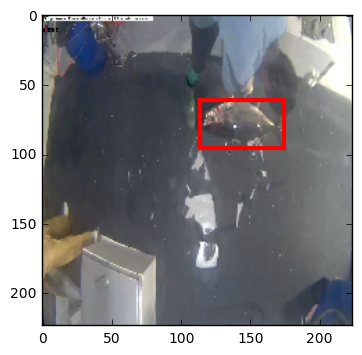

In [40]:
i   = 1
bb  = val_bbox[i]
img = val[i]  #from get_data
show_bb(bb,img)

### Creating and train multi output model.

We are going to train a model with two outputs: location of the bounding boxes and fish category. Why do this

1. Giving the model more to do may actually make it more accurate.  It prevents leakage.
2. We're not allowed to annotate our test images per the rules of kaggle.  We can't tell the model where the fish
   is in a training image.  We'll train a model to learn where the fish is. If we want to know where the model thinks    the fish is, we can ask it.
3. Related to 1 and 2: We're helping fix the leakage problem

In [46]:
p = 0.6

In [51]:
#functional Keras model
last_cl_shape = conv_layers[-1].output_shape[1:]
print(last_cl_shape)

i = Input(last_cl_shape)
x = MaxPooling2D()(i)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_class = Dense(8, activation='softmax', name='class')(x)
x_bb = Dense(4, name='bb')(x) #linear activation?


#often you see BatchNorm then Dropout


(512, 14, 14)


In [52]:
#handle multiple outputs with an array (so simple)
#output loss functions have very different scales so you need to weight them different so that they have roughly the same value when normalized by the weights.
mmodel = Model(i, [x_class, x_bb])
mmodel.compile(Adam(lr=0.001), loss=['categorical_crossentropy', 'mse'], loss_weights=[1., 0.001], metrics=['accuracy'])

In [58]:
mmodel.fit(conv_feat, [trn_labels, trn_bbox], nb_epoch=10, batch_size=batch_size, 
                    validation_data=(conv_val_feat, [val_labels, val_bbox]))




Train on 3060 samples, validate on 717 samples
Epoch 1/10
3060/3060 [==============================] - 2s - loss: 6.2300 - class_loss: 1.1861 - bb_loss: 5043.8951 - class_acc: 0.6598 - bb_acc: 0.4222 - val_loss: 4.9322 - val_class_loss: 0.9471 - val_bb_loss: 3985.0331 - val_class_acc: 0.8619 - val_bb_acc: 0.5091
Epoch 2/10
3060/3060 [==============================] - 2s - loss: 5.1211 - class_loss: 0.3356 - bb_loss: 4785.4857 - class_acc: 0.8977 - bb_acc: 0.5304 - val_loss: 4.2478 - val_class_loss: 0.3726 - val_bb_loss: 3875.1642 - val_class_acc: 0.9303 - val_bb_acc: 0.6039
Epoch 3/10
3060/3060 [==============================] - 2s - loss: 4.5035 - class_loss: 0.1499 - bb_loss: 4353.5980 - class_acc: 0.9559 - bb_acc: 0.5611 - val_loss: 3.7586 - val_class_loss: 0.2679 - val_bb_loss: 3490.7113 - val_class_acc: 0.9414 - val_bb_acc: 0.6192
Epoch 4/10
3060/3060 [==============================] - 2s - loss: 3.8613 - class_loss: 0.0932 - bb_loss: 3768.1154 - class_acc: 0.9761 - bb_acc: 0.5797

In [59]:
#jumping around a little.  Can we do better?
model.optimizer.lr = 1e-5


In [60]:
mmodel.fit(conv_feat, [trn_labels, trn_bbox], nb_epoch=10, batch_size=batch_size, 
                    validation_data=(conv_val_feat, [val_labels, val_bbox]))

Train on 3060 samples, validate on 717 samples
Epoch 1/10
3060/3060 [==============================] - 2s - loss: 0.3091 - class_loss: 0.0225 - bb_loss: 286.5843 - class_acc: 0.9944 - bb_acc: 0.8095 - val_loss: 0.5090 - val_class_loss: 0.2351 - val_bb_loss: 273.9050 - val_class_acc: 0.9568 - val_bb_acc: 0.8647
Epoch 2/10
3060/3060 [==============================] - 2s - loss: 0.2717 - class_loss: 0.0203 - bb_loss: 251.3935 - class_acc: 0.9938 - bb_acc: 0.8059 - val_loss: 0.4608 - val_class_loss: 0.2153 - val_bb_loss: 245.5057 - val_class_acc: 0.9596 - val_bb_acc: 0.8619
Epoch 3/10
3060/3060 [==============================] - 2s - loss: 0.2674 - class_loss: 0.0298 - bb_loss: 237.5483 - class_acc: 0.9925 - bb_acc: 0.8000 - val_loss: 0.4572 - val_class_loss: 0.2222 - val_bb_loss: 234.9350 - val_class_acc: 0.9609 - val_bb_acc: 0.8466
Epoch 4/10
3060/3060 [==============================] - 2s - loss: 0.2382 - class_loss: 0.0155 - bb_loss: 222.6818 - class_acc: 0.9954 - bb_acc: 0.7918 - val_

In [65]:
pred = mmodel.predict(conv_val_feat[:10])

def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[1][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

In [69]:
show_bb_pred(9)


In [71]:
print mmodel.metrics_names
mmodel.evaluate(conv_val_feat, [val_labels, val_bbox])
# 'loss' must be dot product of weighted loss

['loss', 'class_loss', 'bb_loss', 'class_acc', 'bb_acc']
704/717 [============================>.] - ETA: 0s

[0.45347740626900435,
 0.24572430066994913,
 207.75309474631166,
 0.95536959553695955,
 0.83124128312412826]

In [74]:
mmodel.save_weights(path+'results/bn_anno.h5')


### VGG with bigger Images



In [11]:
bw, bh = 360, 640

#tell VGG to use larger images
vgg640 =Vgg16BN((bw, bh)) #adding the size creates VGG without dense layers at the top. 

#pop off last layer of VGG. Use a convolutional layer.
vgg640.model.pop() #pops the max polling layer
vgg640.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 360, 640)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 362, 642)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 360, 640)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 362, 642)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [ ]:
#get input images.
trn = get_data(path+'train',target_size=(bw,bh))
val = get_data(path+'valid',target_size=(bw,bh))


In [17]:
print trn.__class__, trn.shape

#same input images in large arrays.
save_array(path + 'results/trn_640.dat', trn)
save_array(path + 'results/val_640.dat', val)

<type 'numpy.ndarray'> (3060, 3, 360, 640)


In [14]:
trn = load_array(path + 'results/trn_640.dat')

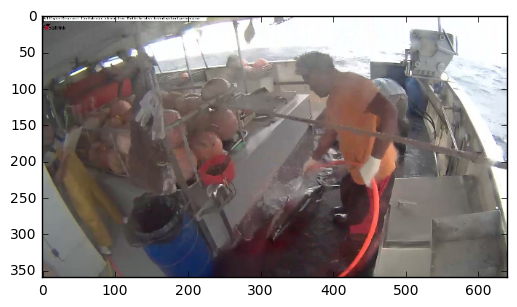

In [20]:
plot(trn[0])

#### Use a Generator for big images

In [11]:
del trn
del val

NameError: name 'trn' is not defined

In [18]:
batch_size = 32


In [27]:
gen  = keras.preprocessing.image.ImageDataGenerator()
tgen = gen.flow_from_directory(path+'train',
                               target_size=(360, 640), 
                               batch_size=batch_size, #shrunk the batch_size to fit in GPU memory. 
                               shuffle=False) #don't forget the shuffle=false


Found 3060 images belonging to 8 classes.


In [ ]:
#these do the same thing...
print vgg640.model.get_layer('convolution2d_78').output_shape[1:]
print vgg640.model.layers[-1].output_shape[1:]

In [28]:
vgg640.model.compile(Adam(lr=0.001), 'categorical_crossentropy', metrics=['acc'])


In [30]:
#predict convolutional layer tensor (generator)
conv_feat = vgg640.model.predict_generator(tgen, 3060)  #batch size provided to the generator

In [29]:
#repeat for the validation data

gen  = keras.preprocessing.image.ImageDataGenerator()
vgen = gen.flow_from_directory(path+'valid',
                              target_size=(360, 640), batch_size=32, shuffle=False) #shrunk the batch_size to fit in GPU memory.



Found 717 images belonging to 8 classes.


In [31]:
conv_val_feat = vgg640.model.predict_generator(vgen, 717)  #batch size provided to the generator

In [ ]:

# predict convolutional layer tensor (in memory)
conv_feat = vgg640.model.predict(trn, batch_size=batch_size)
conv_val_feat = vgg640.model.predict(val, batch_size=batch_size)




In [32]:
save_array(path+'results/conv_feat_640.dat', conv_feat)
save_array(path+'results/conv_val_feat_640.dat', conv_val_feat)

In [28]:
conv_feat = load_array(path+'results/conv_feat_640.dat')
conv_val_feat = load_array(path+'results/conv_val_feat_640.dat')

In [ ]:
# Throw this out...
split_at(vgg640.model, 'Convolution2D')

inp = Input(shape=())
x = BatchNormalization()(inp)
x = Dense()(x)
x = Dropout()(x)

### Fully Connected Blocks

We have larger images.  Dense layers would create tons of parameters for SGD to learn and would blow up memory on the GPU.  Let's try a fully convolution network.


In [16]:
num_filters = 128
num_classes = 8
p = 0.

# border_mode = 'same' keeps the input layer size and output layer size the same

# TODO: learn more about
# 1. border mode
# 2. Activation
# 3. GlobalAveragePooling

def get_fcn():
    
    last_cl_shape = vgg640.model.layers[-1].output_shape[1:]
    
    #trying to see if I understand how the functional api works
    inp = Input(shape=last_cl_shape)

    start =[
        #BatchNormalization(axis=1)(inp) #didn't work :)
        BatchNormalization(axis=1, input_shape=last_cl_shape)
    ]
    
    end = [
        Convolution2D(num_classes, 3,3, activation='relu', border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]
    return start + get_fcn_convblock() + get_fcn_convblock() + get_fcn_convblock((1,2)) + end


def get_fcn_convblock(mps=(2,2)):
    return [
        Convolution2D(num_filters, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(mps),
    ]

In [33]:
fcn_model = Sequential(get_fcn())
fcn_model.compile(Adam(), loss='categorical_crossentropy', metrics=['acc'])

th


### Learning Rate Range Test

This gets us ready to try a Cyclical learning rate.

In [34]:
#test everything working. 
fcn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=2, validation_data=(conv_val_feat, val_labels))

Train on 3060 samples, validate on 717 samples
Epoch 1/2
3060/3060 [==============================] - 18s - loss: 0.7625 - acc: 0.7614 - val_loss: 0.8631 - val_acc: 0.7057
Epoch 2/2
3060/3060 [==============================] - 18s - loss: 0.1920 - acc: 0.9441 - val_loss: 0.3263 - val_acc: 0.9066


In [14]:
LRs = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00009, 0.0001, 0.00011, 0.00012, 0.00015, 0.00018, 0.00021, 0.00024]
acc = {} 

for lr in LRs: 
    #you need a new model each time.
    fcn_model = Sequential(get_fcn())
    fcn_model.compile(Adam(), loss='categorical_crossentropy', metrics=['acc'])
    fcn_model.optimizer.lr = lr
    h = fcn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=8, validation_data=(conv_val_feat, val_labels))
    run_acc = h.history['acc'][-1]
    acc[lr] = run_acc
    print h.history.keys()
    print run_acc, lr
    
print acc

th
Train on 3060 samples, validate on 717 samples
Epoch 1/8
3060/3060 [==============================] - 15s - loss: 2.1530 - acc: 0.1180 - val_loss: 2.0396 - val_acc: 0.2441
Epoch 2/8
3060/3060 [==============================] - 15s - loss: 1.8663 - acc: 0.3690 - val_loss: 1.7957 - val_acc: 0.4463
Epoch 3/8
3060/3060 [==============================] - 15s - loss: 1.7428 - acc: 0.4363 - val_loss: 1.7746 - val_acc: 0.4407
Epoch 4/8
3060/3060 [==============================] - 15s - loss: 1.6757 - acc: 0.4471 - val_loss: 1.7565 - val_acc: 0.4393
Epoch 5/8
3060/3060 [==============================] - 15s - loss: 1.6352 - acc: 0.4503 - val_loss: 1.7396 - val_acc: 0.4338
Epoch 6/8
3060/3060 [==============================] - 15s - loss: 1.6052 - acc: 0.4529 - val_loss: 1.7158 - val_acc: 0.4365
Epoch 7/8
3060/3060 [==============================] - 15s - loss: 1.5793 - acc: 0.4549 - val_loss: 1.7011 - val_acc: 0.4407
Epoch 8/8
3060/3060 [==============================] - 16s - loss: 1.5593 -

In [19]:
#calculate some more accuracies
LRs = [0.00027, 0.00030, 0.00050, 0.00060]

for lr in LRs: 
    #you need a new model each time.
    fcn_model = Sequential(get_fcn())
    fcn_model.compile(Adam(), loss='categorical_crossentropy', metrics=['acc'])
    fcn_model.optimizer.lr = lr
    h = fcn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=8, validation_data=(conv_val_feat, val_labels))
    run_acc = h.history['acc'][-1]
    acc[lr] = run_acc
    print h.history.keys()
    print run_acc, lr
    
print acc

th
Train on 3060 samples, validate on 717 samples
Epoch 1/8
3060/3060 [==============================] - 16s - loss: 1.7238 - acc: 0.4190 - val_loss: 1.9714 - val_acc: 0.1464
Epoch 2/8
3060/3060 [==============================] - 15s - loss: 1.4634 - acc: 0.4739 - val_loss: 1.8639 - val_acc: 0.3445
Epoch 3/8
3060/3060 [==============================] - 15s - loss: 1.2618 - acc: 0.5634 - val_loss: 1.8648 - val_acc: 0.3891
Epoch 4/8
3060/3060 [==============================] - 15s - loss: 1.0058 - acc: 0.6765 - val_loss: 1.9725 - val_acc: 0.2134
Epoch 5/8
3060/3060 [==============================] - 16s - loss: 0.7226 - acc: 0.7984 - val_loss: 1.9324 - val_acc: 0.2594
Epoch 6/8
3060/3060 [==============================] - 15s - loss: 0.4630 - acc: 0.8892 - val_loss: 2.0308 - val_acc: 0.2357
Epoch 7/8
3060/3060 [==============================] - 16s - loss: 0.2881 - acc: 0.9389 - val_loss: 2.0564 - val_acc: 0.2845
Epoch 8/8
3060/3060 [==============================] - 16s - loss: 0.1777 -

In [20]:
import matplotlib.pyplot as plt

skeys = sorted(acc.keys())
svals = []

for k in skeys:
        svals.append(acc[k])
    
plt.title('Learning Rate Test')
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')
#plt.legend(['train', 'test'], loc='upper left')
plt.plot(skeys, svals)
plt.show()


In [22]:
trn_labels.shape[0]

3060

In [25]:
#cyclical learning rate
nb_samples = trn_labels.shape[0]
ss  = 6* (nb_samples / batch_size)
clr = CyclicLR(base_lr=1e-5, max_lr=2e-4,step_size=ss)

In [35]:
#this is completely contrived.  Worth doing if you train for much longer.  Not worth it if you're training for a few epochs.
fcn_model.fit(conv_feat, trn_labels, callbacks=[clr], batch_size=batch_size, nb_epoch=12, validation_data=(conv_val_feat, val_labels))

#note - this run done after already training for two epochs (so model already had decent weights)

# JHoward uses bigger training set and with fewer validation cases and therefore beats you on training and validation accuracy.

Train on 3060 samples, validate on 717 samples
Epoch 1/12
3060/3060 [==============================] - 18s - loss: 0.0804 - acc: 0.9807 - val_loss: 0.2029 - val_acc: 0.9442
Epoch 2/12
3060/3060 [==============================] - 18s - loss: 0.0434 - acc: 0.9918 - val_loss: 0.1830 - val_acc: 0.9484
Epoch 3/12
3060/3060 [==============================] - 18s - loss: 0.0272 - acc: 0.9977 - val_loss: 0.1745 - val_acc: 0.9456
Epoch 4/12
3060/3060 [==============================] - 18s - loss: 0.0181 - acc: 0.9980 - val_loss: 0.1683 - val_acc: 0.9498
Epoch 5/12
3060/3060 [==============================] - 18s - loss: 0.0107 - acc: 0.9990 - val_loss: 0.1772 - val_acc: 0.9442
Epoch 6/12
3060/3060 [==============================] - 18s - loss: 0.0078 - acc: 0.9993 - val_loss: 0.1666 - val_acc: 0.9498
Epoch 7/12
3060/3060 [==============================] - 18s - loss: 0.0044 - acc: 1.0000 - val_loss: 0.1649 - val_acc: 0.9540
Epoch 8/12
3060/3060 [==============================] - 18s - loss: 0.0

heat map

In [36]:
import scipy.misc

last_c2d_640 = fcn_model.layers[-4].output
first_layer_inp_640 = fcn_model.layers[0].input
conv_fn = K.function([first_layer_inp_640, K.learning_phase()], last_c2d_640) #really not sure what this line does. 

def convo_map(inp, label):
        conv = conv_fn([inp,0])[0, label]
        return scipy.misc.imresize(conv, (360,640), interp='nearest')

In [47]:

one_a = np.expand_dims(conv_feat[0], 0)
np.round(fcn_model.predict(one_a)[0], 2)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [46]:
vgen.reset()
vbatch = vgen.next()
plot(vbatch[0][0])

In [48]:
cm = convo_map(one_a, 0)
plt.imshow(cm, cmap="cool")

[ 1.  0.  0.  0.  0.  0.  0.  0.]


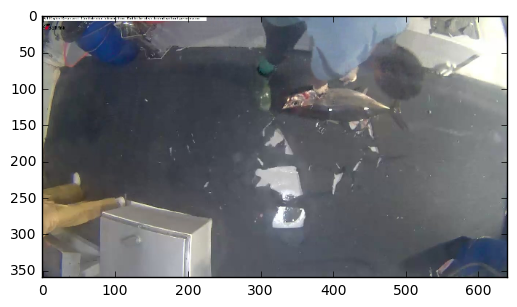

In [54]:
ind = 1
one_a = np.expand_dims(conv_feat[ind], 0)
print(np.round(fcn_model.predict(one_a)[0], 2))

vgen.reset()
vbatch = vgen.next()
#plot(vbatch[0][ind])
plt.imshow(to_plot(vbatch[0][ind]))




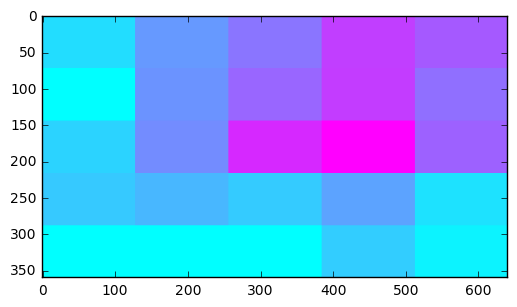

In [55]:
cm = convo_map(one_a, 0)
plt.imshow(cm, cmap="cool")

[ 1.  0.  0.  0.  0.  0.  0.  0.]


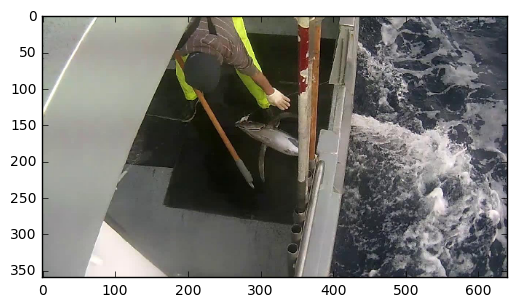

In [52]:
ind = 25
one_a = np.expand_dims(conv_feat[ind], 0)
print(np.round(fcn_model.predict(one_a)[0], 2))

vgen.reset()
vbatch = vgen.next()
plot(vbatch[0][ind])

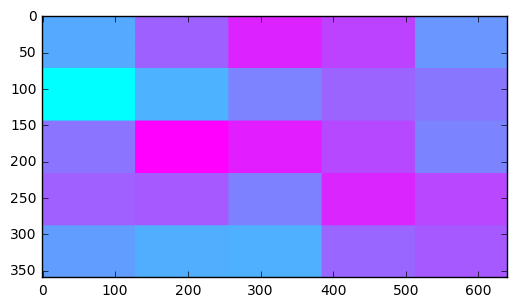

In [53]:
cm = convo_map(one_a, 0)
plt.imshow(cm, cmap="cool")

### Inception mini-net

In [20]:
#function to do a 2d convolution followed by a batchnorm
def c2dbn(x, nf, w, h, stride=(1,1)):
    x = Convolution2D(nf, w, h, subsample=stride, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)


#function for one inception block
def incept_block(x):
    #path1
    b11 = c2dbn(x, 32, 1, 1, stride=(2,2))# 1x1
    
    #path2
    b55 = c2dbn(x, 24, 1, 1, ) 
    b55 = c2dbn(b55, 32, 5, 5, stride=(2,2))
    
    #path 3
    b33 = c2dbn(x, 32, 1, 1)
    b33 = c2dbn(b33, 48, 3, 3)
    b33 = c2dbn(b33, 48, 3, 3, stride=(2,2))
    
    #path 4
    bp = AveragePooling2D((3,3), strides=(2,2), border_mode='same')(x)
    bp = c2dbn(bp, 16, 1, 1)
    
    #concatentate blocks 
    return merge([b11, b55, b33, bp], mode='concat', concat_axis=1)

In [21]:
#created an inception model that trains on top of the large VGG model last convo layer.  
p = 0.75

#input
#lgm_out_shape = vgg640.model.layers[-1].output_shape[1:]

#fake data...
lgm_out_shape=(128,56,56)

inp = Input(shape=lgm_out_shape)
#batchnorm
x = BatchNormalization(axis=1)(inp)

#three inception blocks
x = incept_block(x)
x = incept_block(x)
x = incept_block(x)

#dropout
x = Dropout(p)(x)

#Convolution to 8 filters (for outputs)
x = Convolution2D(8, 3,3)(x)

#global average pooling
x   = GlobalAveragePooling2D()(x)

#activation
out = Activation('softmax')(x)

#create model from input and output
i_model = Model([inp], out)



In [22]:
i_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 128, 56, 56)   0                                            
____________________________________________________________________________________________________
batchnormalization_61 (BatchNorm (None, 128, 56, 56)   512         input_5[0][0]                    
____________________________________________________________________________________________________
convolution2d_62 (Convolution2D) (None, 32, 56, 56)    4128        batchnormalization_61[0][0]      
____________________________________________________________________________________________________
batchnormalization_65 (BatchNorm (None, 32, 56, 56)    128         convolution2d_62[0][0]           
___________________________________________________________________________________________

In [30]:
i_model.compile(Adam(), loss='categorical_crossentropy', metrics=['acc'])

In [31]:
i_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3060 samples, validate on 717 samples
Epoch 1/2
3060/3060 [==============================] - 19s - loss: 1.4820 - acc: 0.5412 - val_loss: 1.4335 - val_acc: 0.6137
Epoch 2/2
3060/3060 [==============================] - 18s - loss: 0.5103 - acc: 0.8324 - val_loss: 1.0828 - val_acc: 0.8033


In [38]:
i_model.optimizer.lr

<CudaNdarrayType(float32, scalar)>

In [39]:
i_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3060 samples, validate on 717 samples
Epoch 1/2
3060/3060 [==============================] - 18s - loss: 0.2532 - acc: 0.9203 - val_loss: 0.6714 - val_acc: 0.8745
Epoch 2/2
3060/3060 [==============================] - 18s - loss: 0.1345 - acc: 0.9605 - val_loss: 0.4147 - val_acc: 0.8870


In [ ]:
i_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3060 samples, validate on 717 samples
Epoch 1/2
3060/3060 [==============================] - 18s - loss: 0.0706 - acc: 0.9840 - val_loss: 0.2992 - val_acc: 0.9191
Epoch 2/2
2112/3060 [===================>..........] - ETA: 5s - loss: 0.0513 - acc: 0.9882